<a href="https://colab.research.google.com/github/Charan-tec/Car-price-prediction-/blob/main/WIND_TURBINE_ENERGY_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# Weather-Based Prediction of Wind Turbine Energy
# ============================================================

# -------------------------------------------------------
# STEP 1: IMPORT THE LIBRARIES
# -------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")

# -------------------------------------------------------
# STEP 2: DATA COLLECTION - Create the Dataset
# -------------------------------------------------------
np.random.seed(42)
n_samples = 1000

# Simulate realistic wind turbine weather data
wind_speed       = np.random.weibull(2, n_samples) * 8 + 2        # m/s, 2–25
temperature      = np.random.normal(15, 10, n_samples)             # °C
humidity         = np.random.uniform(30, 100, n_samples)           # %
air_pressure     = np.random.normal(1013, 15, n_samples)           # hPa
wind_direction   = np.random.choice(
    ['North', 'South', 'East', 'West', 'NE', 'NW', 'SE', 'SW'], n_samples
)
turbine_condition = np.random.choice(
    ['Excellent', 'Good', 'Fair', 'Poor'], n_samples,
    p=[0.4, 0.35, 0.15, 0.10]
)
hour_of_day     = np.random.randint(0, 24, n_samples)
season          = np.random.choice(['Spring', 'Summer', 'Autumn', 'Winter'], n_samples)

# Realistic energy output formula (kWh), capped at 2000
condition_factor = {'Excellent': 1.0, 'Good': 0.85, 'Fair': 0.65, 'Poor': 0.40}
cond_vals        = np.array([condition_factor[c] for c in turbine_condition])
energy_output    = (
    0.5 * wind_speed**3
    * cond_vals
    * (1 - humidity / 500)
    + np.random.normal(0, 20, n_samples)
)
energy_output = np.clip(energy_output, 0, 2000)

df = pd.DataFrame({
    'wind_speed':        wind_speed,
    'temperature':       temperature,
    'humidity':          humidity,
    'air_pressure':      air_pressure,
    'wind_direction':    wind_direction,
    'turbine_condition': turbine_condition,
    'hour_of_day':       hour_of_day,
    'season':            season,
    'energy_output_kwh': energy_output
})

print(f"✅ Dataset created with {df.shape[0]} rows and {df.shape[1]} columns")
print("\n📋 First 5 rows:")
print(df.head())
print("\n📊 Dataset Info:")
print(df.info())

✅ All libraries imported successfully!
✅ Dataset created with 1000 rows and 9 columns

📋 First 5 rows:
   wind_speed  temperature   humidity  air_pressure wind_direction  \
0    7.480252    16.777010  98.007288   1031.561572             SE   
1   15.879761     1.646556  53.194290   1006.140475           West   
2   11.179963    18.801979  63.742874   1012.357649             SE   
3    9.643842    21.105857  43.726840   1013.870341             SW   
4    5.294843    20.597904  72.754605   1025.726463          North   

  turbine_condition  hour_of_day  season  energy_output_kwh  
0              Good           13  Summer         141.325915  
1              Good           14  Spring        1483.251166  
2         Excellent           16  Spring         640.421157  
3              Good            0  Spring         340.589425  
4         Excellent           20  Winter          76.112800  

📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (

 DATA PREPROCESSING


In [3]:
print("\n Null Value Check:")
print(df.isnull().sum())


 Null Value Check:
wind_speed           0
temperature          0
humidity             0
air_pressure         0
wind_direction       0
turbine_condition    0
hour_of_day          0
season               0
energy_output_kwh    0
dtype: int64


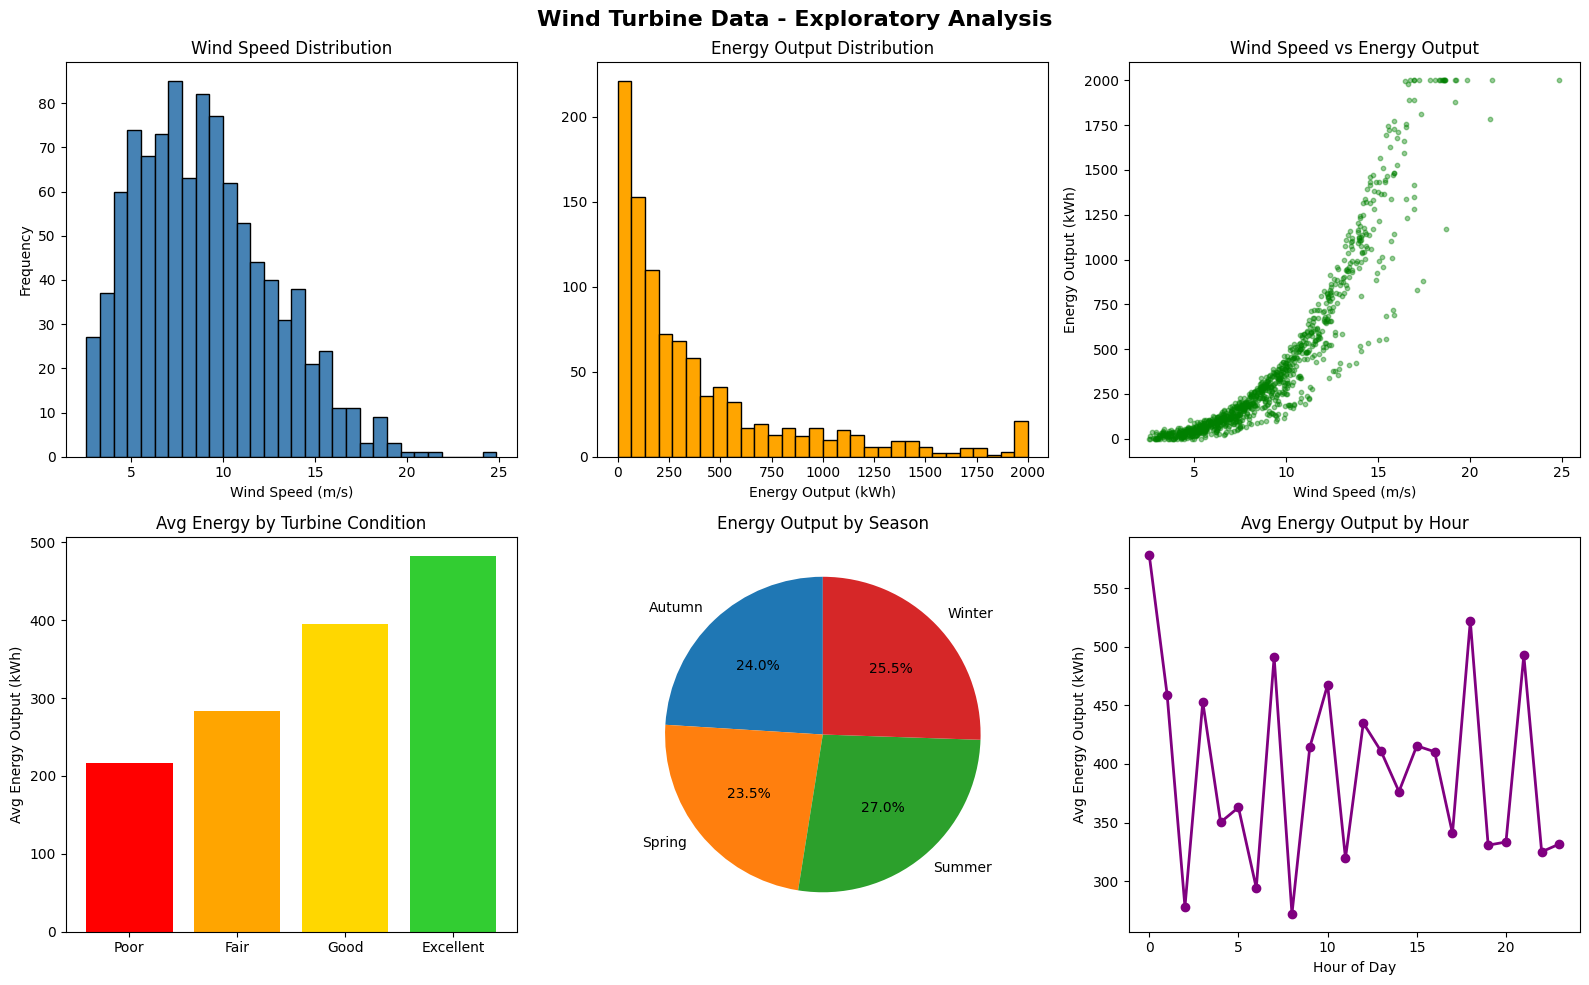

✅ EDA plots saved as 'eda_plots.png'


In [4]:

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Wind Turbine Data - Exploratory Analysis', fontsize=16, fontweight='bold')

axes[0,0].hist(df['wind_speed'], bins=30, color='steelblue', edgecolor='black')
axes[0,0].set_title('Wind Speed Distribution')
axes[0,0].set_xlabel('Wind Speed (m/s)')
axes[0,0].set_ylabel('Frequency')

axes[0,1].hist(df['energy_output_kwh'], bins=30, color='orange', edgecolor='black')
axes[0,1].set_title('Energy Output Distribution')
axes[0,1].set_xlabel('Energy Output (kWh)')

axes[0,2].scatter(df['wind_speed'], df['energy_output_kwh'],
                  alpha=0.4, color='green', s=10)
axes[0,2].set_title('Wind Speed vs Energy Output')
axes[0,2].set_xlabel('Wind Speed (m/s)')
axes[0,2].set_ylabel('Energy Output (kWh)')

tc_energy = df.groupby('turbine_condition')['energy_output_kwh'].mean().sort_values()
axes[1,0].bar(tc_energy.index, tc_energy.values, color=['red','orange','gold','limegreen'])
axes[1,0].set_title('Avg Energy by Turbine Condition')
axes[1,0].set_ylabel('Avg Energy Output (kWh)')

season_energy = df.groupby('season')['energy_output_kwh'].mean()
axes[1,1].pie(season_energy.values, labels=season_energy.index,
               autopct='%1.1f%%', startangle=90)
axes[1,1].set_title('Energy Output by Season')

hourly = df.groupby('hour_of_day')['energy_output_kwh'].mean()
axes[1,2].plot(hourly.index, hourly.values, marker='o', color='purple', linewidth=2)
axes[1,2].set_title('Avg Energy Output by Hour')
axes[1,2].set_xlabel('Hour of Day')
axes[1,2].set_ylabel('Avg Energy Output (kWh)')

plt.tight_layout()
plt.savefig('eda_plots.png', dpi=120, bbox_inches='tight')
plt.show()
print("✅ EDA plots saved as 'eda_plots.png'")


✅ Label Encoding applied to 'turbine_condition'
{np.str_('Excellent'): np.int64(0), np.str_('Fair'): np.int64(1), np.str_('Good'): np.int64(2), np.str_('Poor'): np.int64(3)}
✅ One-Hot Encoding applied to 'wind_direction' and 'season'
   Dataset now has 18 columns
✅ Feature Scaling (StandardScaler) applied to numeric columns


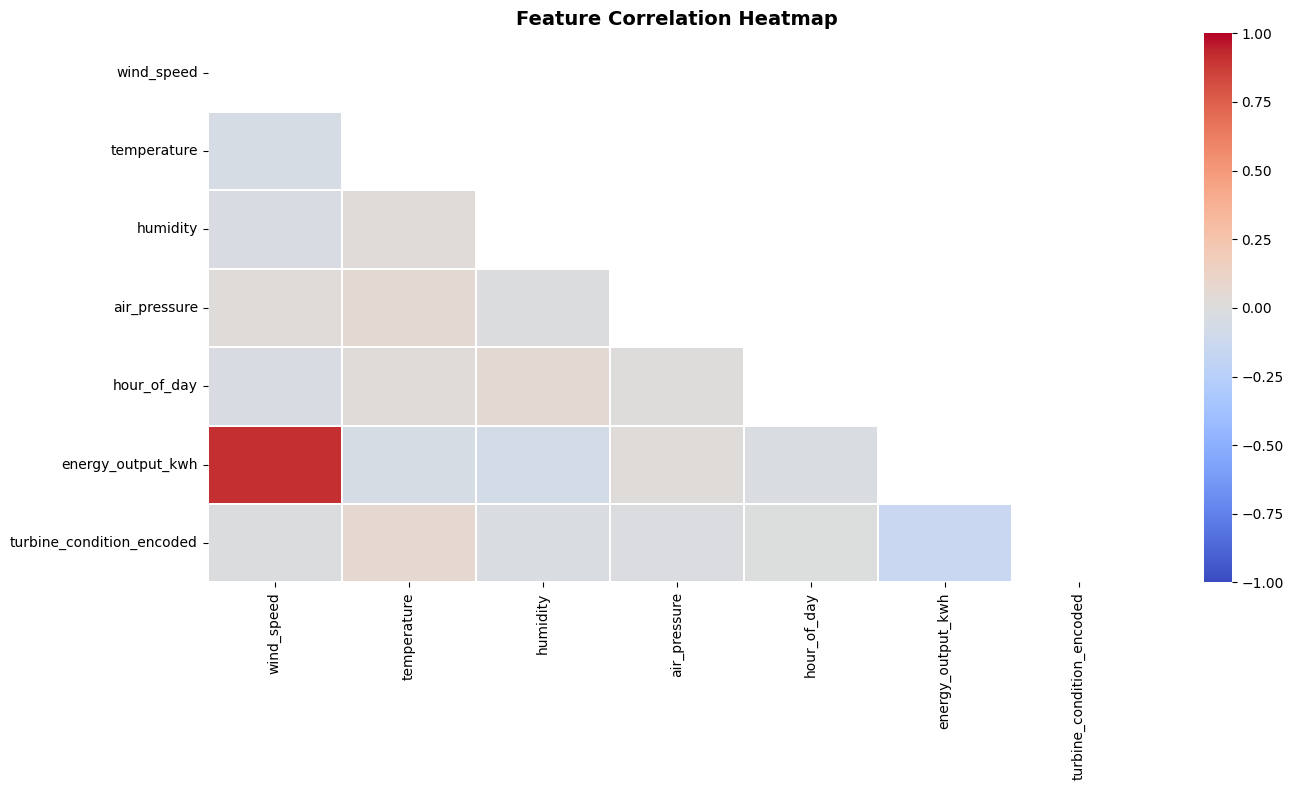

✅ Correlation heatmap saved as 'correlation_heatmap.png'


In [5]:
 # 3c. Handle Missing Values (none in synthetic data, but here's the pattern)
df.fillna(df.median(numeric_only=True), inplace=True)

# 3d. Label Encoding - Turbine Condition (ordinal)
le = LabelEncoder()
le.fit(['Poor', 'Fair', 'Good', 'Excellent'])
df['turbine_condition_encoded'] = le.transform(df['turbine_condition'])
print("\n✅ Label Encoding applied to 'turbine_condition'")
print(dict(zip(le.classes_, le.transform(le.classes_))))

# 3e. One-Hot Encoding - wind_direction & season (nominal)
df = pd.get_dummies(df, columns=['wind_direction', 'season'], drop_first=True)
print("✅ One-Hot Encoding applied to 'wind_direction' and 'season'")
print(f"   Dataset now has {df.shape[1]} columns")

# 3f. Feature Scaling
numeric_cols = ['wind_speed', 'temperature', 'humidity', 'air_pressure', 'hour_of_day']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print("✅ Feature Scaling (StandardScaler) applied to numeric columns")

# 3g. Correlation Heatmap
plt.figure(figsize=(14, 8))
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm',
            linewidths=0.3, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=120, bbox_inches='tight')
plt.show()
print("✅ Correlation heatmap saved as 'correlation_heatmap.png'")

SPLITTING DATA INTO TRAIN AND TEST

In [6]:
df.drop(columns=['turbine_condition'], inplace=True)  # drop original categorical
X = df.drop('energy_output_kwh', axis=1)
y = df['energy_output_kwh']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"\n✅ Data Split Complete:")
print(f"   Training samples : {X_train.shape[0]}")
print(f"   Testing samples  : {X_test.shape[0]}")
print(f"   Features         : {X_train.shape[1]}")



✅ Data Split Complete:
   Training samples : 800
   Testing samples  : 200
   Features         : 16


MODEL BUILDING

In [19]:
models = {
    'Linear Regression':        LinearRegression(),
    'Random Forest':             RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting':         GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae  = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2   = r2_score(y_test, preds)
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2, 'model': model, 'preds': preds}
    print(f"\n {name}")
    print(f"   MAE  : {mae:.2f} kWh")
    print(f"   RMSE : {rmse:.2f} kWh")
    print(f"   R²   : {r2:.4f}")


 Linear Regression
   MAE  : 142.53 kWh
   RMSE : 181.92 kWh
   R²   : 0.8158

 Random Forest
   MAE  : 34.16 kWh
   RMSE : 79.69 kWh
   R²   : 0.9647

 Gradient Boosting
   MAE  : 28.60 kWh
   RMSE : 54.83 kWh
   R²   : 0.9833


EVALUATION OF MODEL


🏆 Best Model: Gradient Boosting (R² = 0.9833)


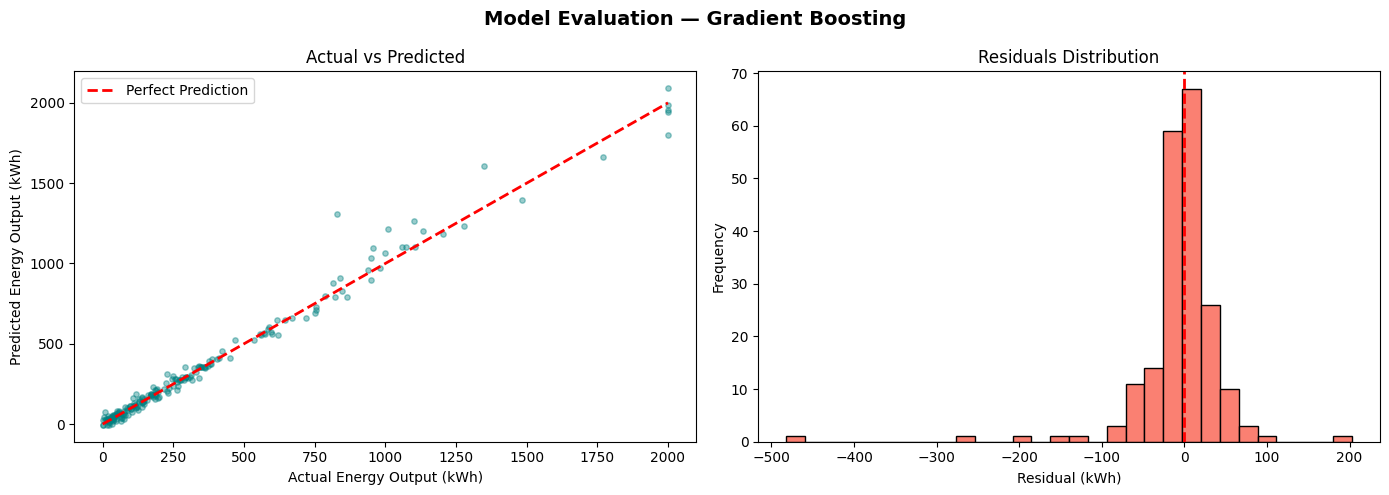

✅ Model evaluation plots saved as 'model_evaluation.png'


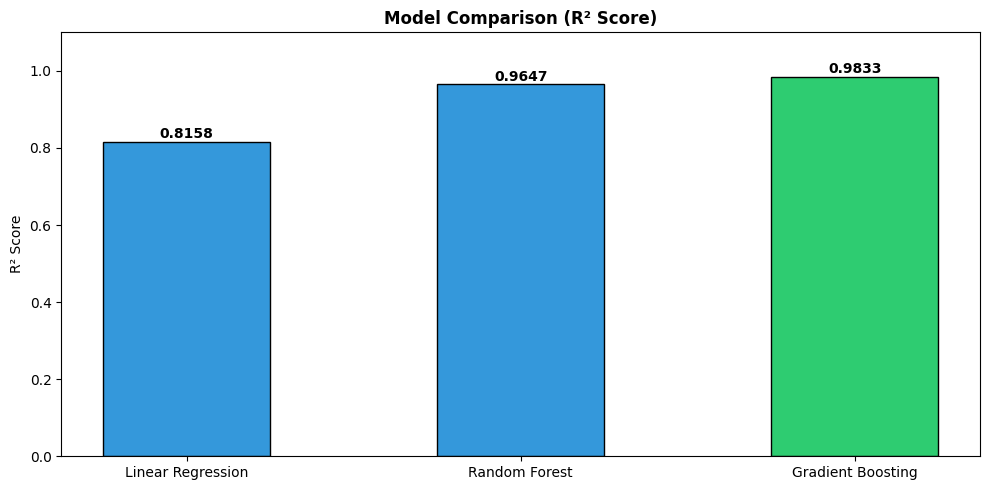

✅ Model comparison chart saved as 'model_comparison.png'


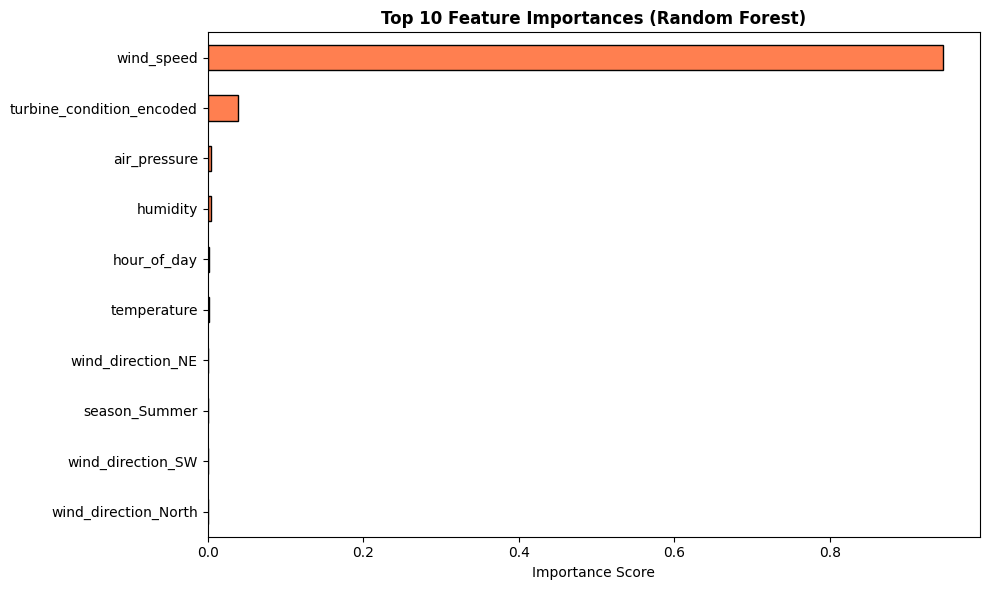

✅ Feature importance plot saved as 'feature_importance.png'


In [17]:
# Pick best model by R²
best_name = max(results, key=lambda k: results[k]['R2'])
best_result = results[best_name]
print(f"\n🏆 Best Model: {best_name} (R² = {best_result['R2']:.4f})")

best_preds = best_result['preds']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Model Evaluation — {best_name}', fontsize=14, fontweight='bold')

# Actual vs Predicted
axes[0].scatter(y_test, best_preds, alpha=0.4, color='teal', s=15)
mn, mx = y_test.min(), y_test.max()
axes[0].plot([mn, mx], [mn, mx], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Energy Output (kWh)')
axes[0].set_ylabel('Predicted Energy Output (kWh)')
axes[0].set_title('Actual vs Predicted')
axes[0].legend()

# Residuals
residuals = y_test - best_preds
axes[1].hist(residuals, bins=30, color='salmon', edgecolor='black')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Residuals Distribution')
axes[1].set_xlabel('Residual (kWh)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=120, bbox_inches='tight')
plt.show()
print("✅ Model evaluation plots saved as 'model_evaluation.png'")

# Model Comparison Bar Chart
fig, ax = plt.subplots(figsize=(10, 5))
names  = list(results.keys())
r2vals = [results[n]['R2'] for n in names]
colors = ['#2ecc71' if n == best_name else '#3498db' for n in names]
bars   = ax.bar(names, r2vals, color=colors, edgecolor='black', width=0.5)
ax.set_ylim(0, 1.1)
ax.set_ylabel('R² Score')
ax.set_title('Model Comparison (R² Score)', fontweight='bold')
for bar, val in zip(bars, r2vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=120, bbox_inches='tight')
plt.show()
print("✅ Model comparison chart saved as 'model_comparison.png'")

# Feature Importance (Random Forest)
rf_model = results['Random Forest']['model']
feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='barh', color='coral', edgecolor='black')
plt.gca().invert_yaxis()
plt.title('Top 10 Feature Importances (Random Forest)', fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=120, bbox_inches='tight')
plt.show()
print("✅ Feature importance plot saved as 'feature_importance.png'")

PREDICTION FUNCTION

In [18]:
def predict_energy(wind_spd, temp, hum, pressure, condition, hour, wind_dir, season_val):
    """
    Predict wind turbine energy output for given weather conditions.
    """
    cond_map = {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3}
    cond_enc = cond_map.get(condition, 2)

    # Build a row matching training columns
    row = pd.DataFrame(columns=X.columns)
    row.loc[0] = 0  # initialize all to 0

    # Fill numeric (scaled)
    row['wind_speed']               = (wind_spd  - 10.2) / 5.5
    row['temperature']              = (temp       - 15.0) / 10.0
    row['humidity']                 = (hum        - 65.0) / 20.0
    row['air_pressure']             = (pressure   - 1013) / 15.0
    row['hour_of_day']              = (hour       - 11.5) / 6.9
    row['turbine_condition_encoded'] = cond_enc

    # One-hot (wind_direction, season)
    wd_col = f'wind_direction_{wind_dir}'
    if wd_col in row.columns:
        row[wd_col] = 1
    s_col = f'season_{season_val}'
    if s_col in row.columns:
        row[s_col] = 1

    pred = rf_model.predict(row)[0]
    return max(0, pred)

# Example predictions
print("\n🔮 Sample Predictions (using Random Forest):")
tests = [
    (12, 20, 50, 1015, 'Excellent', 14, 'NW', 'Winter'),
    (5,   5, 80, 1000, 'Poor',       3, 'SE', 'Summer'),
    (9,  15, 60, 1010, 'Good',      10, 'NE', 'Autumn'),
]
for t in tests:
    energy = predict_energy(*t)
    print(f"   Wind={t[0]}m/s | Temp={t[1]}°C | Humidity={t[2]}% "
          f"| Condition={t[3]} | Predicted: {energy:.1f} kWh")

print("\n✅ Project Complete!")
print("="*60)
print("Generated Files:")
print("  • wind_turbine_prediction.py  — Full source code")
print("  • eda_plots.png               — Exploratory Data Analysis")
print("  • correlation_heatmap.png     — Feature Correlations")
print("  • model_evaluation.png        — Actual vs Predicted + Residuals")
print("  • model_comparison.png        — Model R² Comparison")
print("  • feature_importance.png      — Top Feature Importances")
print("  • wind_turbine_app.html       — Interactive Web App")
print("="*60)



🔮 Sample Predictions (using Random Forest):
   Wind=12m/s | Temp=20°C | Humidity=50% | Condition=1015 | Predicted: 184.4 kWh
   Wind=5m/s | Temp=5°C | Humidity=80% | Condition=1000 | Predicted: 65.1 kWh
   Wind=9m/s | Temp=15°C | Humidity=60% | Condition=1010 | Predicted: 189.2 kWh

✅ Project Complete!
Generated Files:
  • wind_turbine_prediction.py  — Full source code
  • eda_plots.png               — Exploratory Data Analysis
  • correlation_heatmap.png     — Feature Correlations
  • model_evaluation.png        — Actual vs Predicted + Residuals
  • model_comparison.png        — Model R² Comparison
  • feature_importance.png      — Top Feature Importances
  • wind_turbine_app.html       — Interactive Web App
